# Pravin Prakashrao Kulkarni

#### GitHub: https://github.com/pravink83/AIML-IntroToNeuralNetworks

In [294]:
# Import Libraries

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rn

%matplotlib inline

sns.set(color_codes=True)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import resample

import tensorflow as tf

# Load Data

In [295]:
# See if the bank.csv file is in the same folder

if os.path.exists('bank.csv'):
  bankDataOriginal = pd.read_csv('bank.csv')
else:
  drive.mount('/content/drive')
  bankDataOriginal = pd.read_csv('/content/drive/My Drive/AIML/MyProjects/7-IntroductionToNeuralNetwork/bank.csv')

bankDataOriginal.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Preliminary Analysis

In [296]:
# Shape of data
bankDataOriginal.shape

(10000, 14)

In [297]:
rowCount = bankDataOriginal.shape[0]
rowCount

10000

In [298]:
# Data Types
bankDataOriginal.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [299]:
# Null check
bankDataOriginal.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [300]:
# number of unique values
bankDataOriginal.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [301]:
# Drop unwanted columns

# Row Number, Customer Id and Surname columns are not useful for this analysis. Let's drop these.

bankData = bankDataOriginal.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

bankData.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [302]:
# Unique values & counts i.e. value counts

for col in bankData.columns:
    print('----------- Value Counts of ', col, ' -----------')
    print(bankData.groupby(by=col)[col].value_counts())
    print('-------------------------------------')
    print()
    

----------- Value Counts of  CreditScore  -----------
CreditScore  CreditScore
350          350              5
351          351              1
358          358              1
359          359              1
363          363              1
                           ... 
846          846              5
847          847              6
848          848              5
849          849              8
850          850            233
Name: CreditScore, Length: 460, dtype: int64
-------------------------------------

----------- Value Counts of  Geography  -----------
Geography  Geography
France     France       5014
Germany    Germany      2509
Spain      Spain        2477
Name: Geography, dtype: int64
-------------------------------------

----------- Value Counts of  Gender  -----------
Gender  Gender
Female  Female    4543
Male    Male      5457
Name: Gender, dtype: int64
-------------------------------------

----------- Value Counts of  Age  -----------
Age  Age
18   18     22
19   19   

# Univariate Analysis

In [303]:
# Statistical summary of numeric columns
bankData.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [304]:
def getQuartileCounts(col):
    print('Quartile Analysis of ', col)
    print()
    Min = bankData[col].min()
    Max = bankData[col].max()
    Std = bankData[col].std()
    Mean = bankData[col].mean()
    Median = bankData[col].median()
    Q1 = bankData[col].quantile(q=0.25)
    Q2 = bankData[col].quantile(q=0.50)
    Q3 = bankData[col].quantile(q=0.75)
    IQR = Q3-Q1
    Minimum = Q1 - (1.5 * IQR)
    Maximum = Q3 + (1.5 * IQR)
    LeftOutlierCount = bankData[bankData[col]<Minimum].shape[0]
    Q1Count = bankData[(bankData[col]>=Minimum) & (bankData[col]<=Q1)].shape[0]
    Q2Count = bankData[(bankData[col]>Q1) & (bankData[col]<=Q2)].shape[0]
    Q3Count = bankData[(bankData[col]>Q2) & (bankData[col]<=Q3)].shape[0]
    Q4Count = bankData[(bankData[col]>Q3) & (bankData[col]<=Maximum)].shape[0]
    RightOutlierCount = bankData[bankData[col]>Maximum].shape[0]
    print('Min ', Min, " Value count: ", bankData[bankData[col] == Min].shape[0])
    print('Max ', Max, " Value count: ", bankData[bankData[col] == Max].shape[0])
    print()
    print('Standard Deviation ', Std)
    print('Mean ', Mean)
    print('Median ', Median)
    print()
    print('25th percentile Q1 ', Q1)
    print('50th percentile Q2 ', Q2)
    print('75th percentile Q3 ', Q3)
    print('IQR ', IQR)
    print('Minimum = Q1 - 1.5*IQR = ', Minimum)
    print('Maximum = Q3 + 1.5*IQR = ', Maximum)
    print()
    print('Left outlier count i.e. < Minimum  ', LeftOutlierCount)
    print('>= Minimum and <= Q1 count         ', Q1Count)
    print('> Q1 and <= Q2 count               ', Q2Count)
    print('> Q2 and <= Q3 count               ', Q3Count)
    print('> Q3 and <= Maximum                ', Q4Count)
    print('Right outlier count i.e. > Maximum ', RightOutlierCount)
    print('Total Outliers ', (LeftOutlierCount+RightOutlierCount), '  ', (LeftOutlierCount+RightOutlierCount)*100/rowCount, '%', ' of total records')
    print()
    if(Mean > Median):
        print('Distribution is Right Skewed because Mean > Median')
    elif(Mean < Median):
        print('Distribution is Left Skewed because Mean < Median')
    else:
        print('Distribution is Symmetric because Mean = Median')
        
        
def plotUnivariate(col, pltType):
    if (pltType == 'box-dist'):
        fig, axes = plt.subplots(1, 2, figsize=[15,5])
        fig.tight_layout(pad=5.0)
        getQuartileCounts(col)
        sns.boxplot(data=bankData, x=col, ax=axes[0]);
        sns.distplot(bankData[col], ax=axes[1]);
    elif (pltType == 'count'):
        sns.countplot(x=col, data=bankData);

Quartile Analysis of  CreditScore

Min  350  Value count:  5
Max  850  Value count:  233

Standard Deviation  96.65329873613061
Mean  650.5288
Median  652.0

25th percentile Q1  584.0
50th percentile Q2  652.0
75th percentile Q3  718.0
IQR  134.0
Minimum = Q1 - 1.5*IQR =  383.0
Maximum = Q3 + 1.5*IQR =  919.0

Left outlier count i.e. < Minimum   15
>= Minimum and <= Q1 count          2519
> Q1 and <= Q2 count                2501
> Q2 and <= Q3 count                2502
> Q3 and <= Maximum                 2463
Right outlier count i.e. > Maximum  0
Total Outliers  15    0.15 %  of total records

Distribution is Left Skewed because Mean < Median


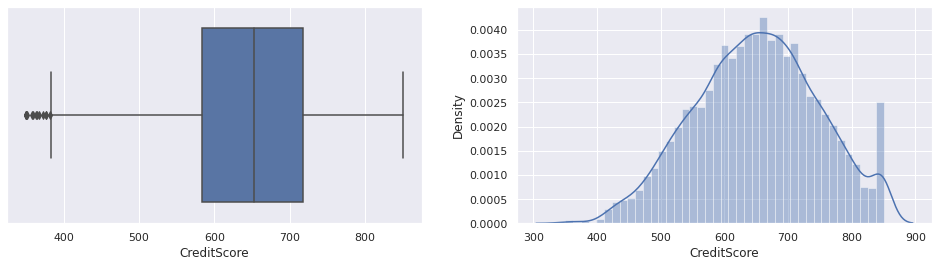

In [305]:
# Plot for CreditScore
plotUnivariate('CreditScore', 'box-dist')

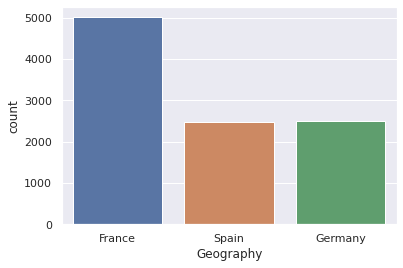

In [306]:
# Plot for Geography
plotUnivariate('Geography', 'count')

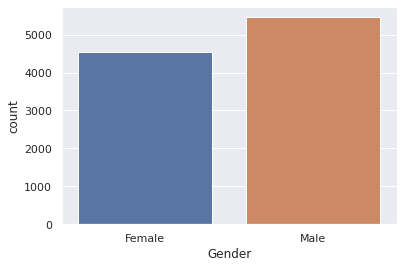

In [307]:
# Plot for Geography
plotUnivariate('Gender', 'count')

Quartile Analysis of  Age

Min  18  Value count:  22
Max  92  Value count:  2

Standard Deviation  10.487806451704591
Mean  38.9218
Median  37.0

25th percentile Q1  32.0
50th percentile Q2  37.0
75th percentile Q3  44.0
IQR  12.0
Minimum = Q1 - 1.5*IQR =  14.0
Maximum = Q3 + 1.5*IQR =  62.0

Left outlier count i.e. < Minimum   0
>= Minimum and <= Q1 count          2790
> Q1 and <= Q2 count                2297
> Q2 and <= Q3 count                2573
> Q3 and <= Maximum                 1981
Right outlier count i.e. > Maximum  359
Total Outliers  359    3.59 %  of total records

Distribution is Right Skewed because Mean > Median


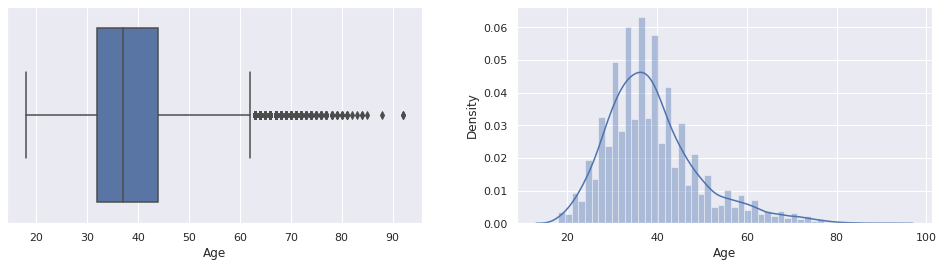

In [308]:
# Plot for Age
plotUnivariate('Age', 'box-dist')

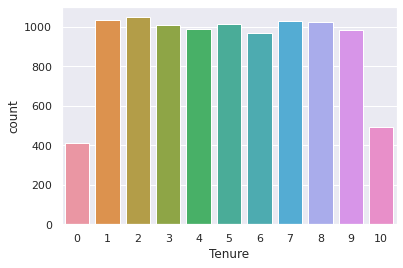

In [309]:
# Plot for Tenure
plotUnivariate('Tenure', 'count')

Quartile Analysis of  Balance

Min  0.0  Value count:  3617
Max  250898.09  Value count:  1

Standard Deviation  62397.40520238623
Mean  76485.88928799961
Median  97198.54000000001

25th percentile Q1  0.0
50th percentile Q2  97198.54000000001
75th percentile Q3  127644.24
IQR  127644.24
Minimum = Q1 - 1.5*IQR =  -191466.36000000002
Maximum = Q3 + 1.5*IQR =  319110.60000000003

Left outlier count i.e. < Minimum   0
>= Minimum and <= Q1 count          3617
> Q1 and <= Q2 count                1383
> Q2 and <= Q3 count                2500
> Q3 and <= Maximum                 2500
Right outlier count i.e. > Maximum  0
Total Outliers  0    0.0 %  of total records

Distribution is Left Skewed because Mean < Median


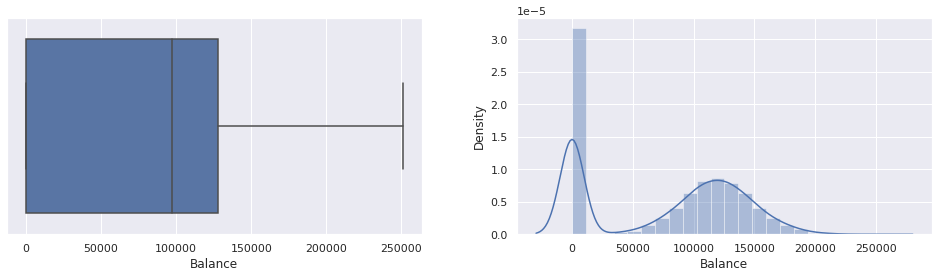

In [310]:
# Plot for Balance
plotUnivariate('Balance', 'box-dist')

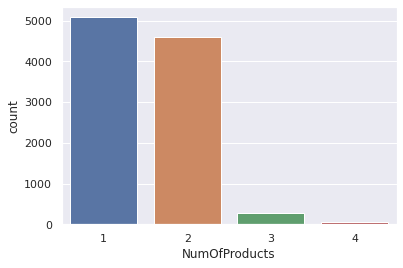

In [311]:
# Plot for NumOfProducts
plotUnivariate('NumOfProducts', 'count')

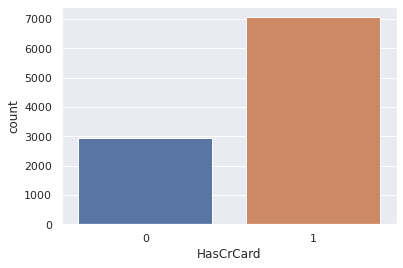

In [312]:
# Plot for HasCrCard
plotUnivariate('HasCrCard', 'count')

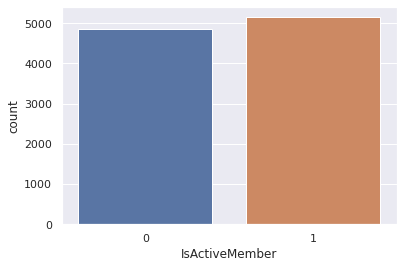

In [313]:
# Plot for IsActiveMember
plotUnivariate('IsActiveMember', 'count')

Quartile Analysis of  EstimatedSalary

Min  11.58  Value count:  1
Max  199992.48  Value count:  1

Standard Deviation  57510.49281769822
Mean  100090.2398809998
Median  100193.915

25th percentile Q1  51002.11
50th percentile Q2  100193.915
75th percentile Q3  149388.2475
IQR  98386.1375
Minimum = Q1 - 1.5*IQR =  -96577.09624999999
Maximum = Q3 + 1.5*IQR =  296967.45375

Left outlier count i.e. < Minimum   0
>= Minimum and <= Q1 count          2500
> Q1 and <= Q2 count                2500
> Q2 and <= Q3 count                2500
> Q3 and <= Maximum                 2500
Right outlier count i.e. > Maximum  0
Total Outliers  0    0.0 %  of total records

Distribution is Left Skewed because Mean < Median


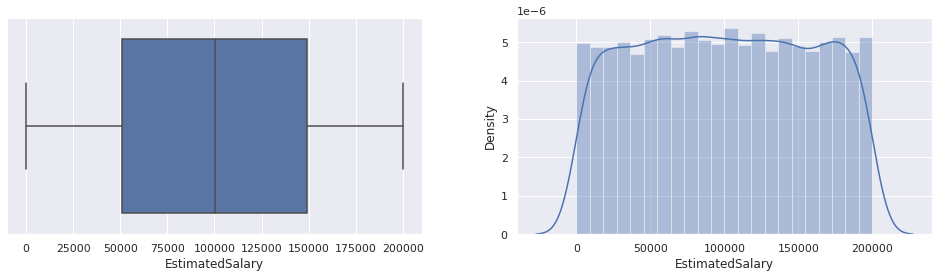

In [314]:
# Plot for Balance
plotUnivariate('EstimatedSalary', 'box-dist')

# Bivariate Analysis

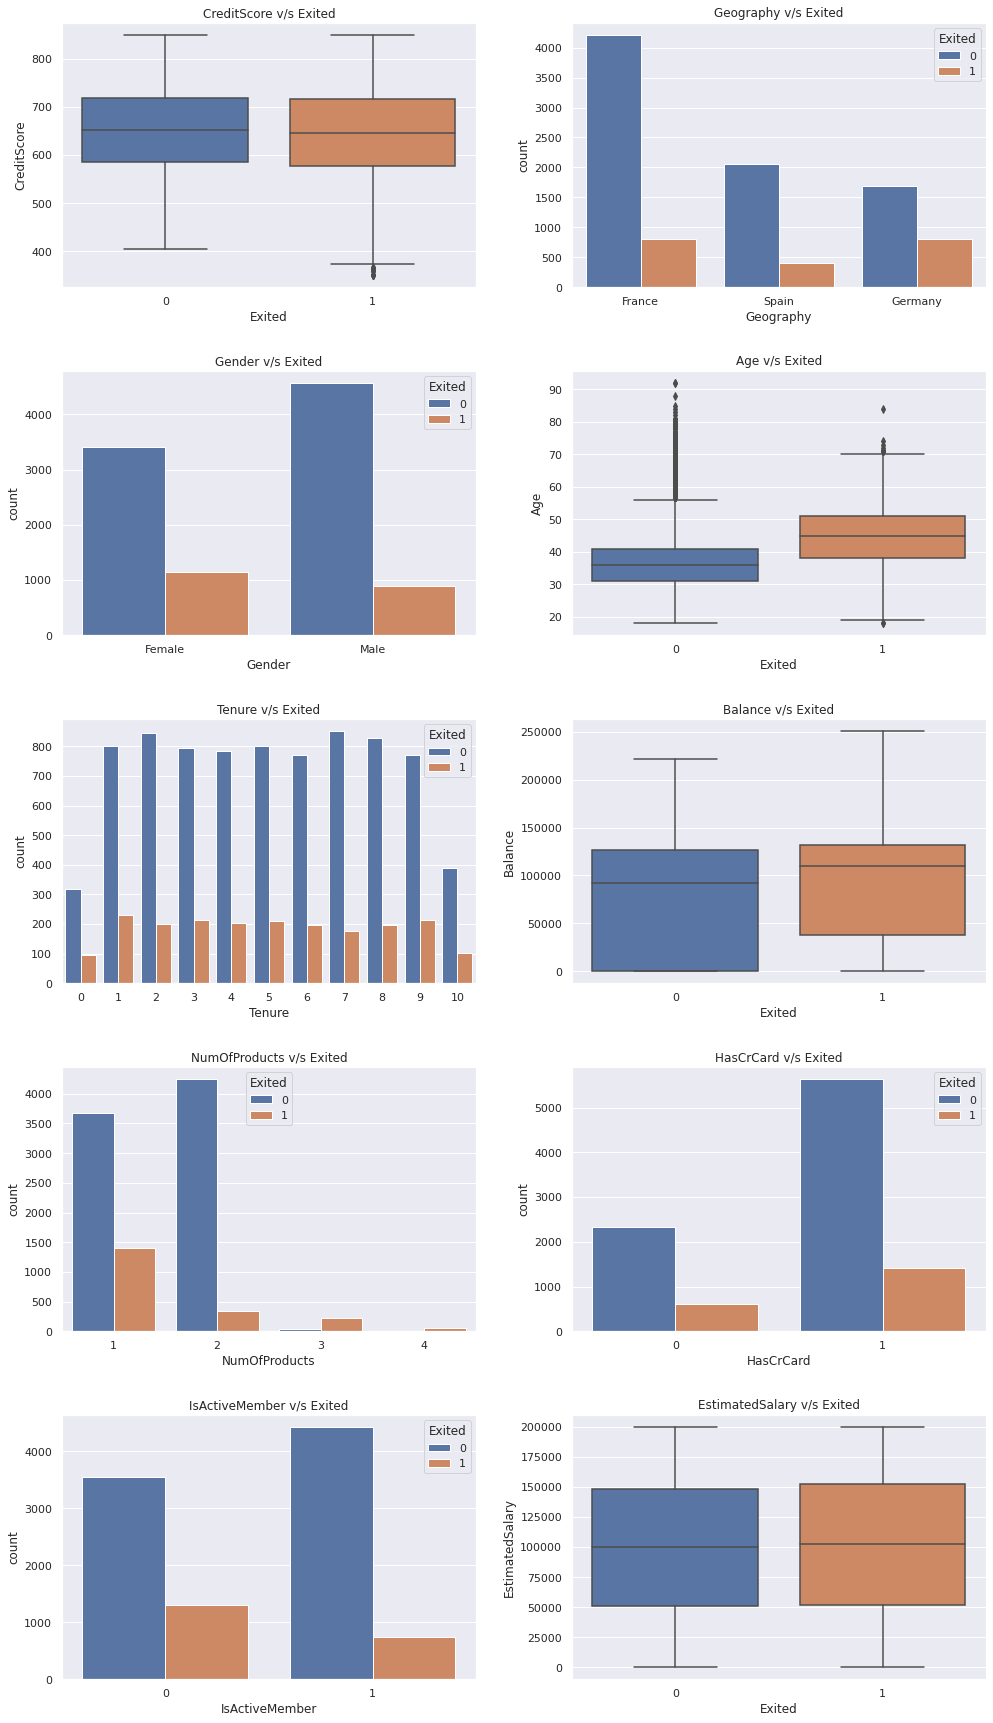

In [315]:
# Bivariate - BoxPlots
# Comparing all numeric columns with Exited column

figure, axes = plt.subplots(5, 2, figsize=(15,25))
figure.tight_layout(pad=5.0)

sns.boxplot(bankData['Exited'], bankData['CreditScore'], ax=axes[0,0]).set_title('CreditScore v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='Geography', ax=axes[0,1]).set_title('Geography v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='Gender', ax=axes[1,0]).set_title('Gender v/s Exited');
sns.boxplot(bankData['Exited'], bankData['Age'], ax=axes[1,1]).set_title('Age v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='Tenure', ax=axes[2,0]).set_title('Tenure v/s Exited');
sns.boxplot(bankData['Exited'], bankData['Balance'], ax=axes[2,1]).set_title('Balance v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='NumOfProducts', ax=axes[3,0]).set_title('NumOfProducts v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='HasCrCard', ax=axes[3,1]).set_title('HasCrCard v/s Exited');
sns.countplot(data=bankData, hue='Exited', x='IsActiveMember', ax=axes[4,0]).set_title('IsActiveMember v/s Exited');
sns.boxplot(bankData['Exited'], bankData['EstimatedSalary'], ax=axes[4,1]).set_title('EstimatedSalary v/s Exited');


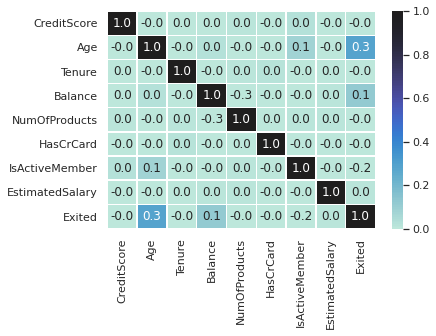

In [316]:
# Heatmap
sns.heatmap(bankData.corr(), annot=True, linewidths=.5, fmt= '.1f', center = 1, vmin=0, vmax=1);

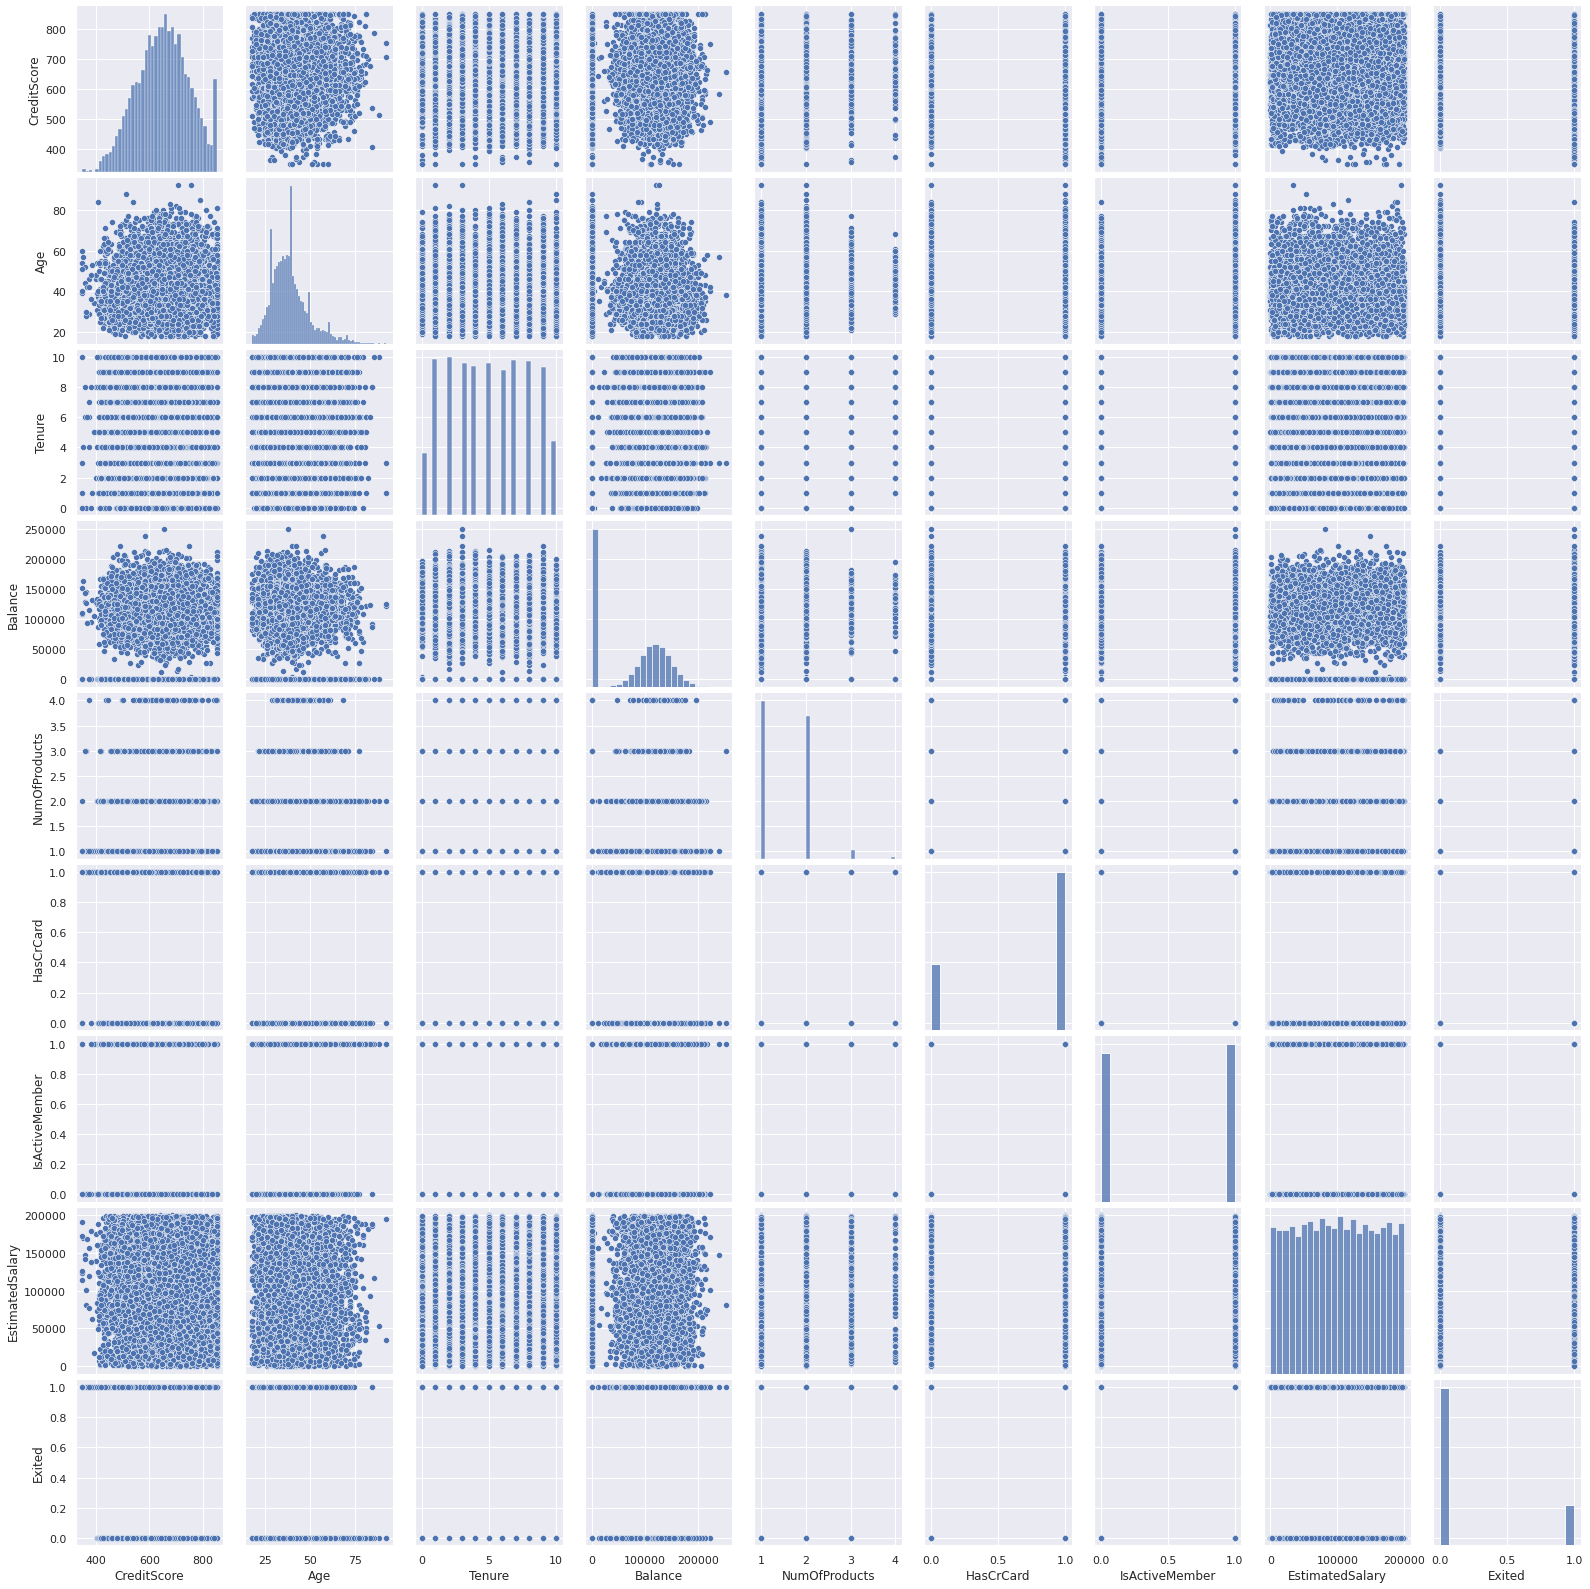

In [317]:
# Pair Plot
sns.pairplot(bankData);

# Data Preprocessing

In [318]:
# Drop First during one-hot encoding is intentionally avoided to keep the column.

bankData = pd.get_dummies(bankData, columns=['Geography', 'Gender'])

bankData.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# Data Imbalance Problem

## From the above preliminary analaysis, value counts of Exited column indicate that the data is not balanced. Let's balance the data with up-sampling

In [319]:
# define variable for random state.
random = 7

In [320]:
bankDataMajority = bankData[bankData['Exited'] == 0]
bankDataMinority = bankData[bankData['Exited'] == 1]

In [321]:
majorityRows = bankDataMajority.shape[0]

In [322]:
minorityUpsampled = resample(bankDataMinority, replace=True, n_samples=majorityRows, random_state=random)

In [323]:
print(minorityUpsampled.shape, bankDataMajority.shape)

(7963, 14) (7963, 14)


In [324]:
bankData = pd.concat([bankDataMajority, minorityUpsampled])
bankData.shape

(15926, 14)

# Data Split

In [325]:
# Create datasets for X (independent) variables.

X = bankData.drop(columns=['Exited'])
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0
6,822,50,7,0.00,2,1,1,10062.80,1,0,0,0,1
8,501,44,4,142051.07,2,0,1,74940.50,1,0,0,0,1


In [326]:
# Create datasets for Y (dependent) variables.

Y = bankData[['Exited']].reset_index().drop(columns=['index'])
Y.head()

,Exited
0,0
1,0
2,0
3,0
4,0


In [327]:
# Split the data
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=random)

In [328]:
# Reset index on split data - This will ease operations like join, concat etc.
X_Train = X_Train.reset_index(drop=True)
X_Test = X_Test.reset_index(drop=True)
Y_Train = Y_Train.reset_index(drop=True)
Y_Test = Y_Test.reset_index(drop=True)

In [329]:
# Verify the split

print("Total Rows in Train Data: ", len(X_Train), '   ', len(X_Train)/rowCount*100, ' %')
print("Total Rows in Test Data: ", len(X_Test), '   ', len(X_Test)/rowCount*100, ' %')

print()

print("Original Set Exited True Values: ",
      len(bankData[bankData['Exited'] == 1]),'  ',
len(bankData[bankData['Exited'] == 1]) / len(bankData) * 100, ' %')

print("Original Set Exited False Values: ",
      len(bankData[bankData['Exited'] == 0]),'  ',
len(bankData[bankData['Exited'] == 0]) / len(bankData) * 100, ' %')

print()

print("Training Set Exited True Values: ",
      len(Y_Train[Y_Train['Exited'] == 1]),'  ',
len(Y_Train[Y_Train['Exited'] == 1]) / len(Y_Train) * 100, ' %')

print("Training Set Exited False Values: ",
      len(Y_Train[Y_Train['Exited'] == 0]),'  ',
len(Y_Train[Y_Train['Exited'] == 0]) / len(Y_Train) * 100, ' %')

print()

print("Test Set Exited True Values: ",
      len(Y_Test[Y_Test['Exited'] == 1]),'  ',
len(Y_Test[Y_Test['Exited'] == 1]) / len(Y_Test) * 100, ' %')

print("Test Set Exited False Values: ",
      len(Y_Test[Y_Test['Exited'] == 0]),'  ',
len(Y_Test[Y_Test['Exited'] == 0]) / len(Y_Test) * 100, ' %')

Total Rows in Train Data:  12740     127.4  %
Total Rows in Test Data:  3186     31.86  %

Original Set Exited True Values:  7963    50.0  %
Original Set Exited False Values:  7963    50.0  %

Training Set Exited True Values:  6336    49.7331240188383  %
Training Set Exited False Values:  6404    50.2668759811617  %

Test Set Exited True Values:  1627    51.06716886377903  %
Test Set Exited False Values:  1559    48.93283113622097  %


# Data Normalize

### During model trials it has been observed that if all columns are standardized the Neural Network model is under-performing. So only 3 columns viz. CreditScore, Balance and Estimated Salary are normalized.

### Moreover, other columns are having a definite set of values, so its better not to normalize them to keep complexity low.

In [330]:
# Only standardize 3 columns viz. CreditScore   Balance  EstimatedSalary
# Do not standardize rest of the columns as those are onehot encoded or have limited set of values.

X_Train_For_Normalize = X_Train.drop(columns=['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male' ])

scalar = preprocessing.StandardScaler()

X_Train_For_Normalize = pd.DataFrame(scalar.fit_transform(X_Train_For_Normalize), columns=X_Train_For_Normalize.columns)

X_Train = pd.concat([X_Train.drop(columns=['CreditScore', 'Balance', 'EstimatedSalary']), X_Train_For_Normalize], axis=1, join='inner')

X_Train.head()

,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore,Balance,EstimatedSalary
0,40,8,3,1,0,0,1,0,0,1,-0.275651,1.501914,1.247908
1,77,3,2,0,1,0,1,0,0,1,1.791870,-0.886466,-1.688781
2,46,3,4,1,0,0,1,0,0,1,0.803941,0.542737,0.525800
3,26,0,1,1,0,1,0,0,1,0,-0.652489,1.048371,0.082096
4,32,4,1,1,1,1,0,0,1,0,1.557619,-0.110156,-1.080627


In [331]:
# Only standardize 3 columns viz. CreditScore   Balance  EstimatedSalary
# Do not standardize rest of the columns as those are onehot encoded or have limited set of values.

X_Test_For_Normalize = X_Test.drop(columns=['Age', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male' ])

scalar = preprocessing.StandardScaler()

X_Test_For_Normalize = pd.DataFrame(scalar.fit_transform(X_Test_For_Normalize), columns=X_Test_For_Normalize.columns)

X_Test = pd.concat([X_Test.drop(columns=['CreditScore', 'Balance', 'EstimatedSalary']), X_Test_For_Normalize], axis=1, join='inner')

X_Test.head()


,Age,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,CreditScore,Balance,EstimatedSalary
0,35,6,2,0,0,0,0,1,1,0,0.145361,-1.357169,-1.652552
1,37,6,2,1,0,1,0,0,1,0,0.145361,-1.357169,-0.816274
2,59,5,1,1,0,0,1,0,1,0,0.529273,0.896390,0.755824
3,23,6,1,1,1,1,0,0,0,1,0.569685,1.370295,0.975943
4,40,6,1,0,0,0,0,1,0,1,-0.703287,-0.315757,-0.409551


# Non-Neural Network Model - Random Forest Classifier

### This model is created to verify what accuracy it can achieve and if neural network models will be able to reach at least that level.

In [332]:
# Define dataframe to collect results
# Various model scores for testing dataset will be stored in this dataframe.

resultsFrame = pd.DataFrame(columns=['Regressor', 'True Positive', 'False Positive', 'True Negative', 'False Negative', 
    'Recall Score', 'Precision Score', 'Accuracy Score', 'F1 Score', 'ROC AUC Score', 'Parameters' ])

In [333]:
# Define a common function to fit the model and calculate various scores and return as a series.

def fitAndPredict(name, model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    accuracy = model.score(x_test, y_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    rocAuc = roc_auc_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    params = str(model.get_params())

    return pd.Series([name, tp, fp, tn, fn, recall, precision,
                                    accuracy, f1, rocAuc, params], index=resultsFrame.columns)

In [334]:
# Create RandomForest Classifier with various parameters and record performance.
criterion = ['gini', 'entropy']
for c in criterion:
    for e in range(50, 110, 50):
        rfcl = RandomForestClassifier(criterion=c, n_estimators=e, random_state=random)
        resultRow = fitAndPredict('RandomForestClassifier', rfcl, X_Train, Y_Train, X_Test, Y_Test)
        resultsFrame = resultsFrame.append(resultRow, ignore_index=True)

In [335]:
resultsFrame

,Regressor,True Positive,False Positive,True Negative,False Negative,Recall Score,Precision Score,Accuracy Score,F1 Score,ROC AUC Score,Parameters
0,RandomForestClassifier,1591,100,1459,36,0.977873,0.940863,0.957313,0.959011,0.956865,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
1,RandomForestClassifier,1592,103,1456,35,0.978488,0.939233,0.956685,0.958459,0.956210,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
2,RandomForestClassifier,1585,90,1469,42,0.974186,0.946269,0.958569,0.960024,0.958228,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,RandomForestClassifier,1593,89,1470,34,0.979103,0.947087,0.961394,0.962829,0.961007,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."


# Data Preparation for Neural Network Models

In [336]:
# To avoid type convert warning on model fit

tf.keras.backend.set_floatx('float64')

# Set various random seeds to generate consistent result 

np.random.seed(random)
rn.seed(random*2)
tf.random.set_seed(random*3)

In [337]:
# Convert the train test data into tensors

X_Train_Tensor = tf.convert_to_tensor(X_Train)
Y_Train_Tensor = tf.convert_to_tensor(Y_Train)
X_Test_Tensor = tf.convert_to_tensor(X_Test)
Y_Test_Tensor = tf.convert_to_tensor(Y_Test)

print("X_Train_Tensor Shape", X_Train_Tensor.shape)
print("Y_Train_Tensor Shape", Y_Train_Tensor.shape)
print("X_Test_Tensor Shape", X_Test_Tensor.shape)
print("Y_Test_Tensor Shape", Y_Test_Tensor.shape)

X_Train_Tensor Shape (12740, 13)
Y_Train_Tensor Shape (12740, 1)
X_Test_Tensor Shape (3186, 13)
Y_Test_Tensor Shape (3186, 1)


# Neural Network Model - 1

## Simple model with one hidden layer having 13 neurons and learning rate of 0.01 with 50 Epochs

In [339]:
# Initialize sequential model

modelOneHiddenLayer = tf.keras.models.Sequential()

# Add first hidden layer - 13 neurons are chosen because we have 13 features.

layer1 = tf.keras.layers.Dense(13, activation='relu', kernel_initializer='normal')

modelOneHiddenLayer.add(layer1)

# Add output layer with 1 neuron as this is binary classification 
outputLayerForOneHiddenLayer = tf.keras.layers.Dense(1, activation = 'sigmoid')

modelOneHiddenLayer.add(outputLayerForOneHiddenLayer)

# Initialize optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model

modelOneHiddenLayer.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Execute model

trainingHistoryOneHiddenLayer = modelOneHiddenLayer.fit(X_Train_Tensor, Y_Train_Tensor, epochs=50, validation_split=0.1)

Epoch 1/50
359/359 [==============================] - 1s 1ms/step - loss: 0.2168 - accuracy: 0.6581 - val_loss: 0.1976 - val_accuracy: 0.7041
Epoch 2/50
359/359 [==============================] - 0s 1ms/step - loss: 0.2022 - accuracy: 0.6901 - val_loss: 0.1949 - val_accuracy: 0.7135
Epoch 3/50
359/359 [==============================] - 0s 1ms/step - loss: 0.2004 - accuracy: 0.6926 - val_loss: 0.1914 - val_accuracy: 0.7206
Epoch 4/50
359/359 [==============================] - 0s 1ms/step - loss: 0.2014 - accuracy: 0.6901 - val_loss: 0.1940 - val_accuracy: 0.7159
Epoch 5/50
359/359 [==============================] - 0s 1ms/step - loss: 0.2006 - accuracy: 0.6957 - val_loss: 0.1929 - val_accuracy: 0.7198
Epoch 6/50
359/359 [==============================] - 0s 1ms/step - loss: 0.2010 - accuracy: 0.6932 - val_loss: 0.1922 - val_accuracy: 0.7237
Epoch 7/50
359/359 [==============================] - 0s 1ms/step - loss: 0.1994 - accuracy: 0.6975 - val_loss: 0.2094 - val_accuracy: 0.6664
Epoch 

In [340]:
modelOneHiddenLayer.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 13)                182       
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 14        
Total params: 196
Trainable params: 196
Non-trainable params: 0
_________________________________________________________________


In [341]:
trainingHistory1H = pd.DataFrame(trainingHistoryOneHiddenLayer.history)

trainingHistory1H['Epoch'] = trainingHistoryOneHiddenLayer.epoch

trainingHistory1H.head()

,loss,accuracy,val_loss,val_accuracy,Epoch
0,0.216758,0.658120,0.197562,0.704082,0
1,0.202164,0.690127,0.194886,0.713501,1
2,0.200409,0.692569,0.191448,0.720565,2
3,0.201439,0.690127,0.194003,0.715856,3
4,0.200635,0.695709,0.192898,0.719780,4


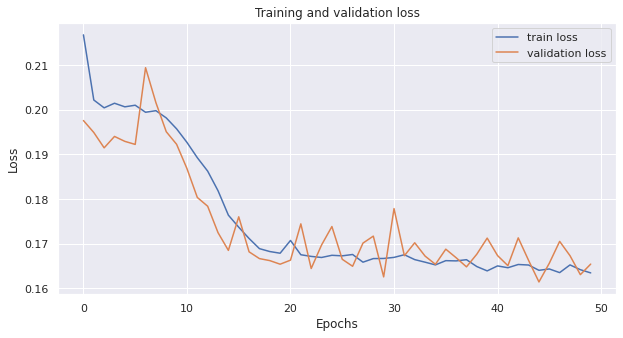

In [342]:
plt.figure(figsize=(10,5))
plt.plot(trainingHistory1H['loss'])
plt.plot(trainingHistory1H['val_loss'])
plt.legend(("train loss", "validation loss"), loc=0);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss');

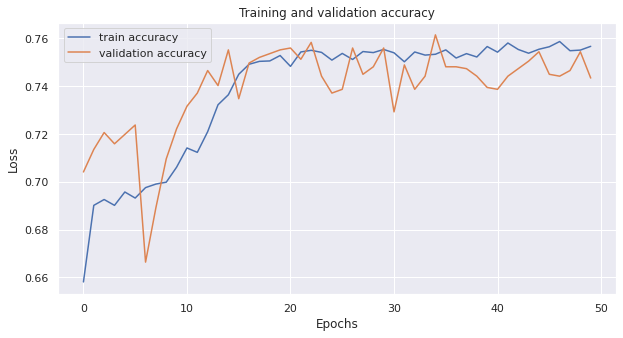

In [343]:
plt.figure(figsize=(10,5))
plt.plot(trainingHistory1H['accuracy'])
plt.plot(trainingHistory1H['val_accuracy'])
plt.legend(("train accuracy", "validation accuracy"), loc=0);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation accuracy');

In [344]:
# Evaluate the model on test data

resultsOneHiddenLayer = modelOneHiddenLayer.evaluate(X_Test, Y_Test)

print(modelOneHiddenLayer.metrics_names)
print(resultsOneHiddenLayer)

100/100 [==============================] - 0s 912us/step - loss: 0.1570 - accuracy: 0.7662
['loss', 'accuracy']
[0.15698689368728266, 0.7661644695543001]


In [345]:
# Predictions with Threshold 0.5

# When > 0.5 then Exited = 1
# When <= 0.5 then Exited = 0

predictions1H = modelOneHiddenLayer.predict(X_Test)

predictions1H = pd.DataFrame(predictions1H, columns=['PredictProbability'])

predictions1H.loc[predictions1H['PredictProbability'] > 0.5, 'Exit_Predicted'] = 1
predictions1H.loc[predictions1H['PredictProbability'] <= 0.5, 'Exit_Predicted'] = 0

Y_Predict1H = predictions1H['Exit_Predicted'].astype('int64')

Y_Predict1H.head()

0    0
1    0
2    1
3    0
4    1
Name: Exit_Predicted, dtype: int64

Accuracy 0.7661644695543001
F1 Score 0.771121351766513
Recall Score 0.7713583282114321
Precision Score 0.7708845208845209
True Negatives :  1186
False Positives :  373
False Negatives :  372
True Positives :  1255


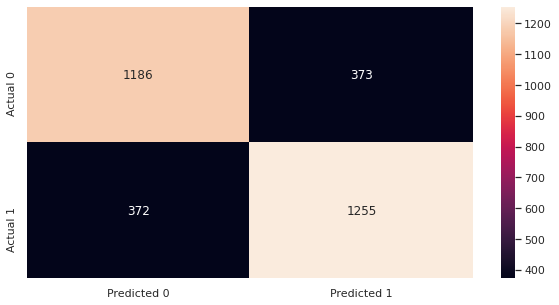

In [346]:
# Scores

print("Accuracy", resultsOneHiddenLayer[1])
print("F1 Score", f1_score(Y_Test, Y_Predict1H))
print("Recall Score", recall_score(Y_Test, Y_Predict1H))
print("Precision Score", precision_score(Y_Test, Y_Predict1H))
cm = confusion_matrix(Y_Test, Y_Predict1H)
tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Predict1H).ravel()

print("True Negatives : ", tn)
print("False Positives : ", fp)
print("False Negatives : ", fn)
print("True Positives : ", tp)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='', xticklabels = ['Predicted 0','Predicted 1'] , yticklabels = ['Actual 0','Actual 1']);


# Neural Network Model - 2 - Improved

In [347]:
# Initialize sequential model

model = tf.keras.models.Sequential()

# Add first hidden layer

layer1 = tf.keras.layers.Dense(130,  activation='softmax', kernel_initializer='random_uniform', bias_initializer='ones') # ,kernel_regularizer=tf.keras.regularizers.L2(0.001))

model.add(layer1)

# Add dropout
model.add(tf.keras.layers.Dropout(0.2))

# Add second hidden layer

layer2 = tf.keras.layers.Dense(130, activation='sigmoid', kernel_initializer='random_uniform', bias_initializer='ones') # ,kernel_regularizer=tf.keras.regularizers.L2(0.001))
                              
model.add(layer2)

# Add dropout
model.add(tf.keras.layers.Dropout(0.2))

# Add third hidden layer

layer3 = tf.keras.layers.Dense(130, activation='relu', kernel_initializer='random_uniform', bias_initializer='ones') # ,kernel_regularizer=tf.keras.regularizers.L2(0.001))

model.add(layer3)

# Add dropout
model.add(tf.keras.layers.Dropout(0.2))

# Add output layer with 1 neuron as this is binary classification 
outputLayer = tf.keras.layers.Dense(1, activation = 'swish', kernel_initializer='random_uniform', bias_initializer='ones')

model.add(outputLayer)

# Initialize optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model

model.compile(optimizer = optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Execute model

trainingHistoryRaw = model.fit(X_Train_Tensor, Y_Train_Tensor, epochs=1000, validation_split=0.1)

Epoch 1/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.2609 - accuracy: 0.5104 - val_loss: 0.2368 - val_accuracy: 0.7206
Epoch 2/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.2290 - accuracy: 0.6285 - val_loss: 0.2072 - val_accuracy: 0.7214
Epoch 3/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.2161 - accuracy: 0.6666 - val_loss: 0.1971 - val_accuracy: 0.7221
Epoch 4/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.2136 - accuracy: 0.6681 - val_loss: 0.1987 - val_accuracy: 0.7096
Epoch 5/1000
359/359 [==============================] - 1s 3ms/step - loss: 0.2104 - accuracy: 0.6805 - val_loss: 0.1950 - val_accuracy: 0.7182
Epoch 6/1000
359/359 [==============================] - 1s 2ms/step - loss: 0.2088 - accuracy: 0.6844 - val_loss: 0.1954 - val_accuracy: 0.7151
Epoch 7/1000
359/359 [==============================] - 1s 2ms/step - loss: 0.2066 - accuracy: 0.6879 - val_loss: 0.2181 - val_accuracy:

In [348]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 130)               1820      
_________________________________________________________________
dropout_30 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 130)               17030     
_________________________________________________________________
dropout_31 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_88 (Dense)             (None, 130)               17030     
_________________________________________________________________
dropout_32 (Dropout)         (None, 130)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 1)               

In [349]:
trainingHistory = pd.DataFrame(trainingHistoryRaw.history)

trainingHistory['Epoch'] = trainingHistoryRaw.epoch

trainingHistory.head()

,loss,accuracy,val_loss,val_accuracy,Epoch
0,0.260883,0.510379,0.236770,0.720565,0
1,0.228986,0.628467,0.207218,0.721350,1
2,0.216127,0.666579,0.197068,0.722135,2
3,0.213640,0.668149,0.198661,0.709576,3
4,0.210362,0.680534,0.194977,0.718210,4


Text(0.5, 1.0, 'Training and validation loss')

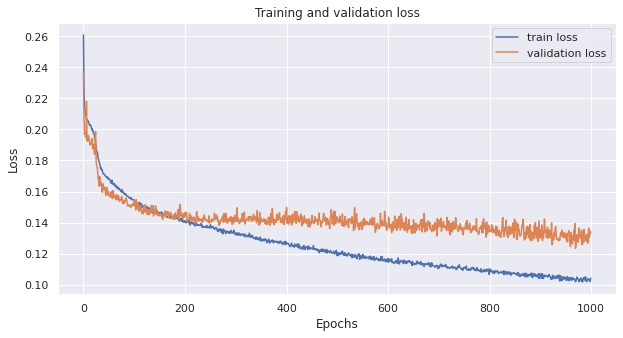

In [350]:
plt.figure(figsize=(10,5))
plt.plot(trainingHistory['loss'])
plt.plot(trainingHistory['val_loss'])
plt.legend(("train loss", "validation loss"), loc=0);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

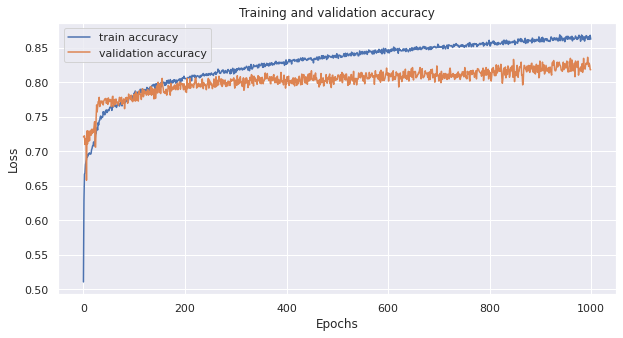

In [351]:
plt.figure(figsize=(10,5))
plt.plot(trainingHistory['accuracy'])
plt.plot(trainingHistory['val_accuracy'])
plt.legend(("train accuracy", "validation accuracy"), loc=0);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation accuracy')

In [352]:
# Evaluate the model on test data

results = model.evaluate(X_Test, Y_Test)

print(model.metrics_names)
print(results)

100/100 [==============================] - 0s 1ms/step - loss: 0.1238 - accuracy: 0.8409
['loss', 'accuracy']
[0.12378922882165388, 0.8408662900188324]


In [353]:
# Predictions with Threshold 0.5

# When > 0.5 then Exited = 1
# When <= 0.5 then Exited = 0


predictions = model.predict(X_Test)

predictions = pd.DataFrame(predictions, columns=['PredictProbability'])

predictions.loc[predictions['PredictProbability'] > 0.5, 'Exit_Predicted'] = 1
predictions.loc[predictions['PredictProbability'] <= 0.5, 'Exit_Predicted'] = 0

Y_Predict = predictions['Exit_Predicted'].astype('int64')

Y_Predict.head()

0    0
1    0
2    1
3    0
4    1
Name: Exit_Predicted, dtype: int64

Accuracy 0.8408662900188324
F1 Score 0.8416119962511716
Recall Score 0.8279041180086048
Precision Score 0.8557814485387548
True Negatives :  1332
False Positives :  227
False Negatives :  280
True Positives :  1347


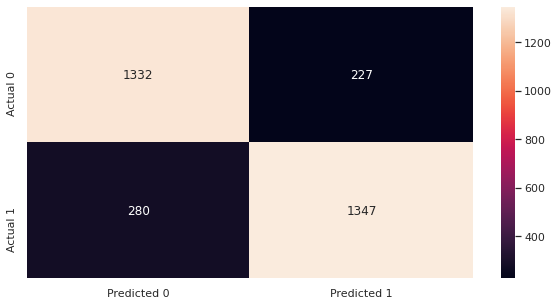

In [354]:
# Scores

print("Accuracy", results[1])
print("F1 Score", f1_score(Y_Test, Y_Predict))
print("Recall Score", recall_score(Y_Test, Y_Predict))
print("Precision Score", precision_score(Y_Test, Y_Predict))
cm = confusion_matrix(Y_Test, Y_Predict)
tn, fp, fn, tp = confusion_matrix(Y_Test, Y_Predict).ravel()

print("True Negatives : ", tn)
print("False Positives : ", fp)
print("False Negatives : ", fn)
print("True Positives : ", tp)

plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='', xticklabels = ['Predicted 0','Predicted 1'] , yticklabels = ['Actual 0','Actual 1']);

# Model Comparison

# Model 1

*   High training speed due to only 1 hidden layer, 13 neurons, high training rate and 50 epochs.

*   Accuracy is comparatively very less than the Random Forest model i.e. approx. 76% over 95% respectively.




#Model 2

* Low training speed due to multiple layers with high number of neurons, low training rate and high number of epochs

* Accuracy of Model 2 (i.e. 84%) is comparatively better than Model 1 (i.e. 76%), however, still relatively lesser than the Random Forest classifier, i.e. 84% over 95% respectively.